In [ ]:
!pip install dwave-ocean-sdk -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.9/150.9 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 57.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.3/102.3 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 62.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 81.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 83.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 76.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.8/223.8 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 3

In [ ]:
!pip install dwave-scikit-learn-plugin -q

DEV-e75d71712e52ab11907dc49a6f03dbdfa4fdc9c1



In [ ]:
!dwave config create

Using the simplified configuration flow.
Try 'dwave config create --full' for more options.

Creating new configuration file: /root/.config/dwave/dwave.conf
Updating existing profile: defaults
Solver API token [skip]: DEV-e75d71712e52ab11907dc49a6f03dbdfa4fdc9c1
Configuration saved.


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from dwave.plugins.sklearn import SelectFromQuadraticModel
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV

In [ ]:
def feature_selection(X, y, num_features):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    quantum_selector = SelectFromQuadraticModel(num_features=num_features, time_limit=5)
    X_train_quantum = quantum_selector.fit_transform(X_train, y_train)
    X_test_quantum = quantum_selector.transform(X_test)

    classifier = RandomForestClassifier(random_state=42)
    rfecv = RFECV(estimator=classifier, step=1, min_features_to_select=num_features, cv=5, scoring='accuracy')
    rfecv.fit(X_train, y_train)

    X_train_classical = rfecv.transform(X_train)
    X_test_classical = rfecv.transform(X_test)

    return X_train_quantum, X_test_quantum, X_train_classical, X_test_classical, y_train, y_test

In [ ]:
def evaluate_classifier(X_train, X_test, y_train, y_test, method):
    clf = RandomForestClassifier(random_state=42)
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    grid_search = GridSearchCV(clf, param_grid, cv=3, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    best_clf = grid_search.best_estimator_

    y_pred = best_clf.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"{method} Method:")
    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-score: {f1}")
    print(f"Confusion Matrix:\n {confusion_matrix(y_test, y_pred)}")
    print(f"Classification Report:\n {classification_report(y_test, y_pred)}")

    return accuracy, precision, recall, f1

In [ ]:
def plot_results(results):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    sns.barplot(x="Method", y="Accuracy", data=results, ax=axes[0, 0])
    axes[0, 0].set_title("Accuracy Comparison")

    sns.barplot(x="Method", y="Precision", data=results, ax=axes[0, 1])
    axes[0, 1].set_title("Precision Comparison")

    sns.barplot(x="Method", y="Recall", data=results, ax=axes[1, 0])
    axes[1, 0].set_title("Recall Comparison")

    sns.barplot(x="Method", y="F1-score", data=results, ax=axes[1, 1])
    axes[1, 1].set_title("F1-score Comparison")

    plt.tight_layout()
    plt.show()

In [ ]:
def run_evaluation(X, y, data_name, num_features):
    X_train_quantum, X_test_quantum, X_train_classical, X_test_classical, y_train, y_test = feature_selection(X, y, num_features)

    quantum_train_df = pd.DataFrame(X_train_quantum)
    quantum_train_df['target'] = y_train
    quantum_test_df = pd.DataFrame(X_test_quantum)
    quantum_test_df['target'] = y_test

    quantum_train_df.to_csv(data_name + ' quantum_train.csv', index=False)
    quantum_test_df.to_csv(data_name + ' quantum_test.csv', index=False)

    classical_train_df = pd.DataFrame(X_train_classical)
    classical_train_df['target'] = y_train
    classical_test_df = pd.DataFrame(X_test_classical)
    classical_test_df['target'] = y_test

    classical_train_df.to_csv(data_name + ' classical_train.csv', index=False)
    classical_test_df.to_csv(data_name + ' classical_test.csv', index=False)

    quantum_results = evaluate_classifier(X_train_quantum, X_test_quantum, y_train, y_test, "Quantum Annealing")
    classical_results = evaluate_classifier(X_train_classical, X_test_classical, y_train, y_test, "Classical")

    results = pd.DataFrame({
        'Method': ['Quantum Annealing', 'Classical'],
        'Accuracy': [quantum_results[0], classical_results[0]],
        'Precision': [quantum_results[1], classical_results[1]],
        'Recall': [quantum_results[2], classical_results[2]],
        'F1-score': [quantum_results[3], classical_results[3]]
    })

    plot_results(results)


In [ ]:
def perform_pca(X, y):
    pca = PCA()
    X_pca = pca.fit_transform(X)

    explained_variance = pca.explained_variance_ratio_

    plt.figure(figsize=(10, 7))
    plt.plot(range(1, len(explained_variance) + 1), np.cumsum(explained_variance), marker='o', linestyle='--')
    plt.title('Explained Variance by Principal Components')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.grid(True)
    plt.show()

    cumulative_variance = np.cumsum(explained_variance)
    num_features = np.argmax(cumulative_variance >= 0.90) + 1  # 90% explained variance threshold

    print(f'Optimal number of principal components: {num_features}')

    return num_features

# d-wave dataset titanic

In [ ]:
import pandas as pd

df = pd.read_csv('/content/formatted_titanic.csv')
df = df.dropna()
df.head()

,pclass,survived,sex,age,fare,cabin,miss,master,mr,mrs,rare,alone,embarked port S,embarked port C,embarked port Q
0,1,1,1,2,2,True,True,False,False,False,False,True,True,False,False
1,1,1,0,0,1,True,False,True,False,False,False,False,True,False,False
2,1,0,1,0,1,True,True,False,False,False,False,False,True,False,False
3,1,0,0,2,1,True,False,False,True,False,False,False,True,False,False
4,1,0,1,2,1,True,False,False,False,True,False,False,True,False,False


In [ ]:
bool_cols = df.select_dtypes(include=['bool']).columns

df[bool_cols] = df[bool_cols].astype(int).astype('float64')

In [ ]:
X = df.drop(columns=['survived']).values
y = df['survived'].values

X = StandardScaler().fit_transform(X)

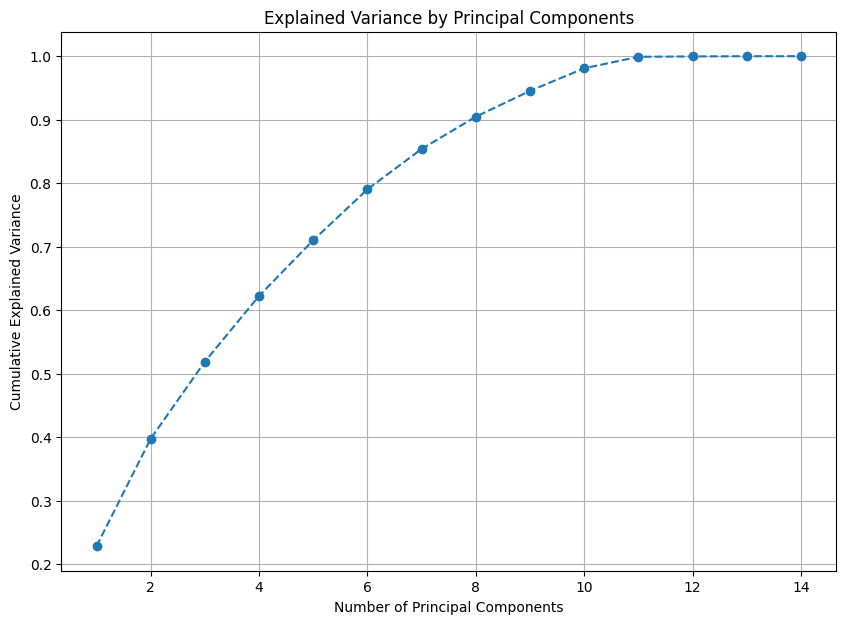

Optimal number of principal components: 8


In [ ]:
num_features = perform_pca(X, y)

Quantum Annealing Method:
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
Accuracy: 0.722488038277512
Precision: 0.7205424124283774
Recall: 0.722488038277512
F1-score: 0.720434344443133
Confusion Matrix:
 [[95 25]
 [33 56]]
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.79      0.77       120
           1       0.69      0.63      0.66        89

    accuracy                           0.72       209
   macro avg       0.72      0.71      0.71       209
weighted avg       0.72      0.72      0.72       209

Classical Method:
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Accuracy: 0.7655502392344498
Precision: 0.7698049595487181
Recall: 0.7655502392344498
F1-score: 0.759302365091492
Confusion Matrix:
 [[106  14]
 [ 35  54]]
Classification Report:
               precision    recall  f1-score   support

           0

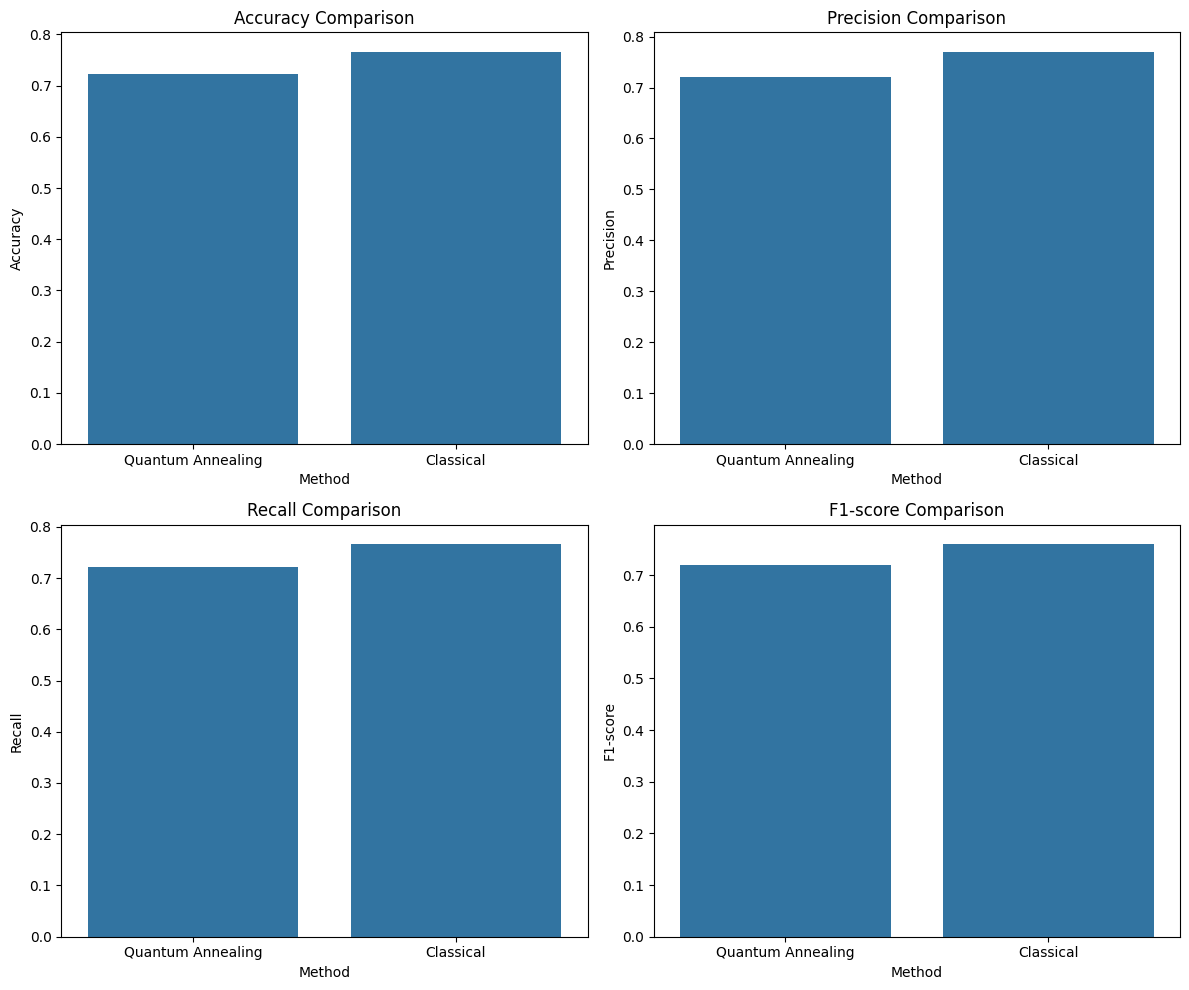

In [ ]:
run_evaluation(X, y, 'titanic', num_features)

# breast cancer

In [ ]:
import pandas as pd

df = pd.read_csv('breast-cancer.csv')
df = df.dropna()
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [ ]:
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})

X = df.drop(columns=['id', 'diagnosis']).values
y = df['diagnosis'].values

X = StandardScaler().fit_transform(X)

In [ ]:
print(X.shape)

(569, 30)


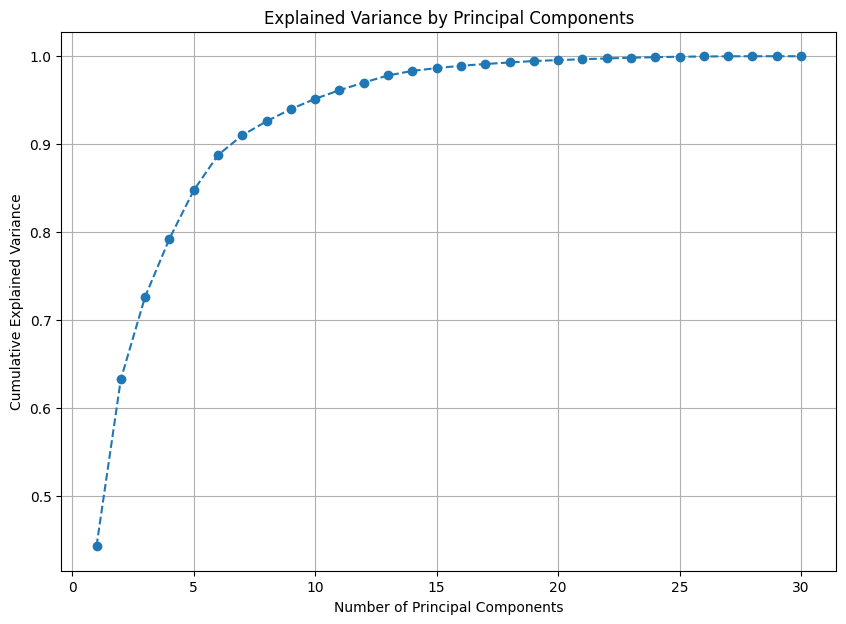

Optimal number of principal components: 7


In [ ]:
num_features = perform_pca(X, y)

Quantum Annealing Method:
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy: 0.9649122807017544
Precision: 0.9652053622194477
Recall: 0.9649122807017544
F1-score: 0.9647382344750767
Confusion Matrix:
 [[70  1]
 [ 3 40]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.97        71
           1       0.98      0.93      0.95        43

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114

Classical Method:
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Accuracy: 0.9649122807017544
Precision: 0.9649122807017544
Recall: 0.9649122807017544
F1-score: 0.9649122807017544
Confusion Matrix:
 [[69  2]
 [ 2 41]]
Classification Report:
               precision    recall  f1-score   support

           

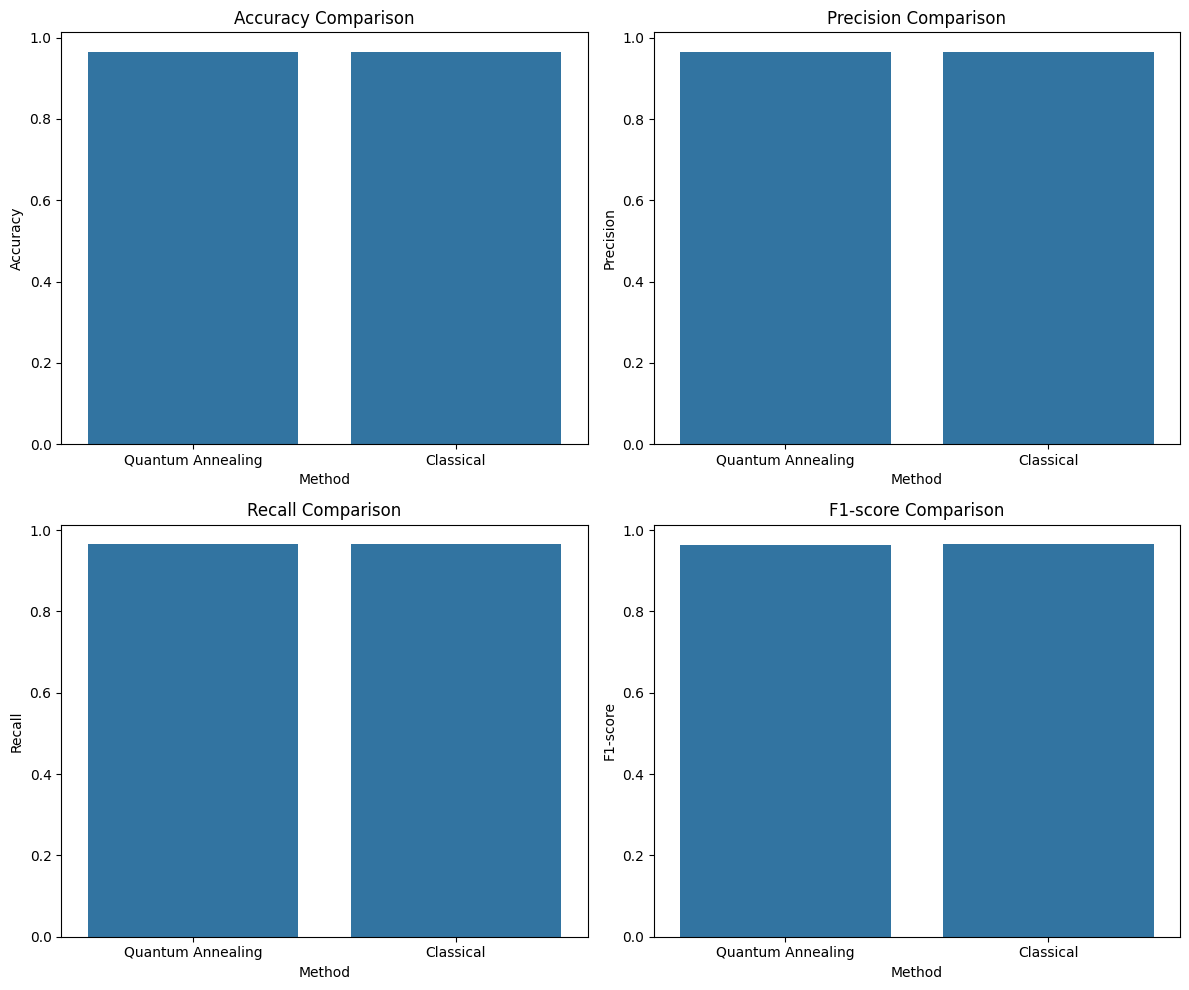

In [ ]:
run_evaluation(X, y, 'breast-cancer', num_features)

# Pima Indians Diabetes

In [ ]:
import pandas as pd

data = pd.read_csv('/content/Pima Indians Diabetes.csv')
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [ ]:
y = data['Outcome']
X = data.drop(columns=['Outcome'])
X = StandardScaler().fit_transform(X)

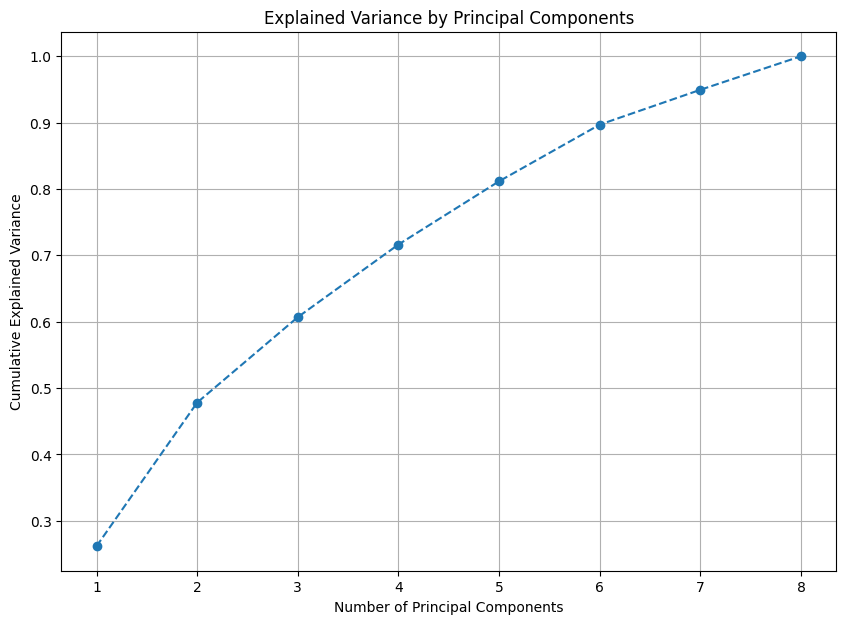

Optimal number of principal components: 7


In [ ]:
num_features = perform_pca(X, y)

Quantum Annealing Method:
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Accuracy: 0.7597402597402597
Precision: 0.7607507288629737
Recall: 0.7597402597402597
F1-score: 0.7602127145274353
Confusion Matrix:
 [[80 19]
 [18 37]]
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.81      0.81        99
           1       0.66      0.67      0.67        55

    accuracy                           0.76       154
   macro avg       0.74      0.74      0.74       154
weighted avg       0.76      0.76      0.76       154

Classical Method:
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Accuracy: 0.7207792207792207
Precision: 0.7196825396825397
Recall: 0.7207792207792207
F1-score: 0.720199951263526
Confusion Matrix:
 [[78 21]
 [22 33]]
Classification Report:
               precision    recall  f1-score   support

           0  

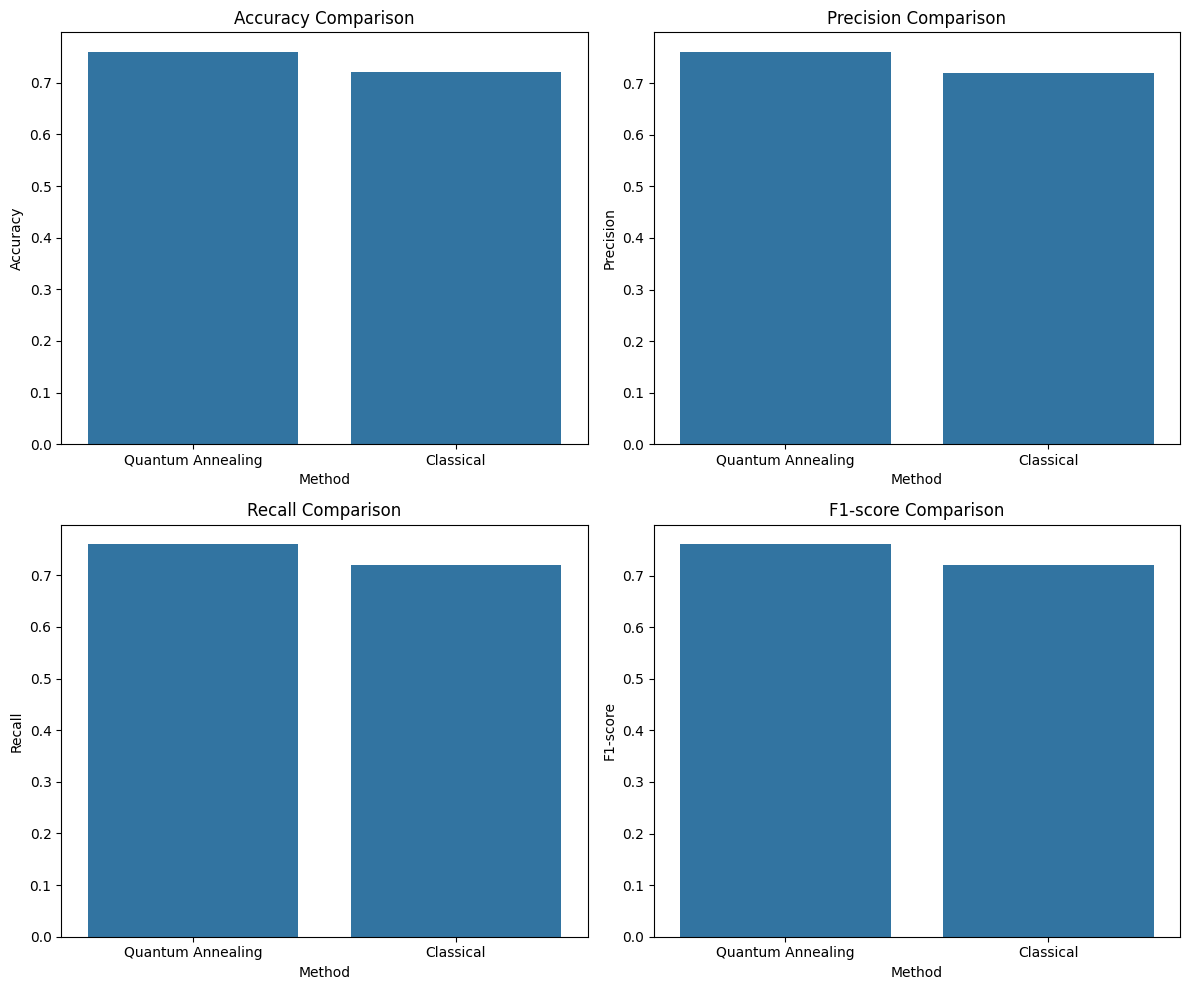

In [ ]:
run_evaluation(X, y, 'Pima Indians Diabetes', num_features)

# Stroke

In [ ]:
import pandas as pd

df = pd.read_csv('/content/Stroke.csv')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [ ]:
df['work_type'].unique()

array(['Private', 'Self-employed', 'Govt_job', 'children', 'Never_worked'],
      dtype=object)

In [ ]:
df = pd.get_dummies(df, columns=['smoking_status'])
df = df.drop(columns=['smoking_status_Unknown'], axis=1)

In [ ]:
df = pd.get_dummies(df, columns=['gender'])
df = df.drop(columns=['gender_Other'], axis=1)

In [ ]:
df = pd.get_dummies(df, columns=['ever_married'])
df = df.drop(columns=['ever_married_No'], axis=1)

In [ ]:
df = pd.get_dummies(df, columns=['Residence_type'])
df = df.drop(columns=['Residence_type_Rural'], axis=1)

In [ ]:
df = pd.get_dummies(df, columns=['work_type'])
df = df.drop(columns=['work_type_Never_worked'], axis=1)

In [ ]:
df = df.drop(columns=['id'], axis=1)

In [ ]:
df = df.dropna()
df = df.astype(int)

In [ ]:
df.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,gender_Female,gender_Male,ever_married_Yes,Residence_type_Urban,work_type_Govt_job,work_type_Private,work_type_Self-employed,work_type_children
0,67,0,1,228,36,1,1,0,0,0,1,1,1,0,1,0,0
2,80,0,1,105,32,1,0,1,0,0,1,1,0,0,1,0,0
3,49,0,0,171,34,1,0,0,1,1,0,1,1,0,1,0,0
4,79,1,0,174,24,1,0,1,0,1,0,1,0,0,0,1,0
5,81,0,0,186,29,1,1,0,0,0,1,1,1,0,1,0,0


In [ ]:
y = df['stroke']
X = df.drop(columns=['stroke'])
X = StandardScaler().fit_transform(X)

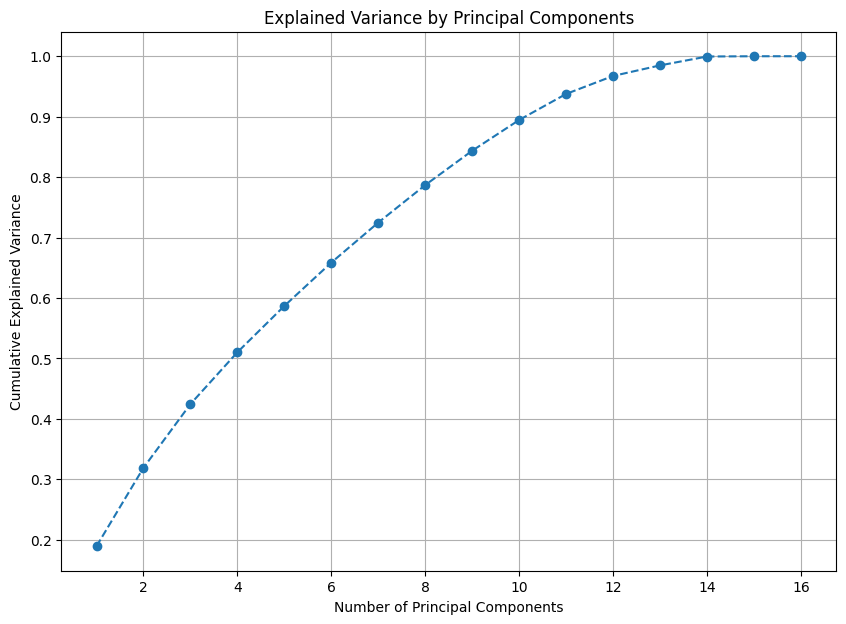

Optimal number of principal components: 11


In [ ]:
num_features = perform_pca(X, y)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:13

Quantum Annealing Method:
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Accuracy: 0.9460285132382892
Precision: 0.8949699478598478
Recall: 0.9460285132382892
F1-score: 0.9197911970678917
Confusion Matrix:
 [[929   0]
 [ 53   0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97       929
           1       0.00      0.00      0.00        53

    accuracy                           0.95       982
   macro avg       0.47      0.50      0.49       982
weighted avg       0.89      0.95      0.92       982

Classical Method:
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
Accuracy: 0.945010183299389
Precision: 0.8949179003925917
Recall: 0.945010183299389
F1-score: 0.9192821573666308
Confusion Matrix:
 [[928   1]
 [ 53   0]]
Classification Report:
               precision    recall  f1-score   support

       

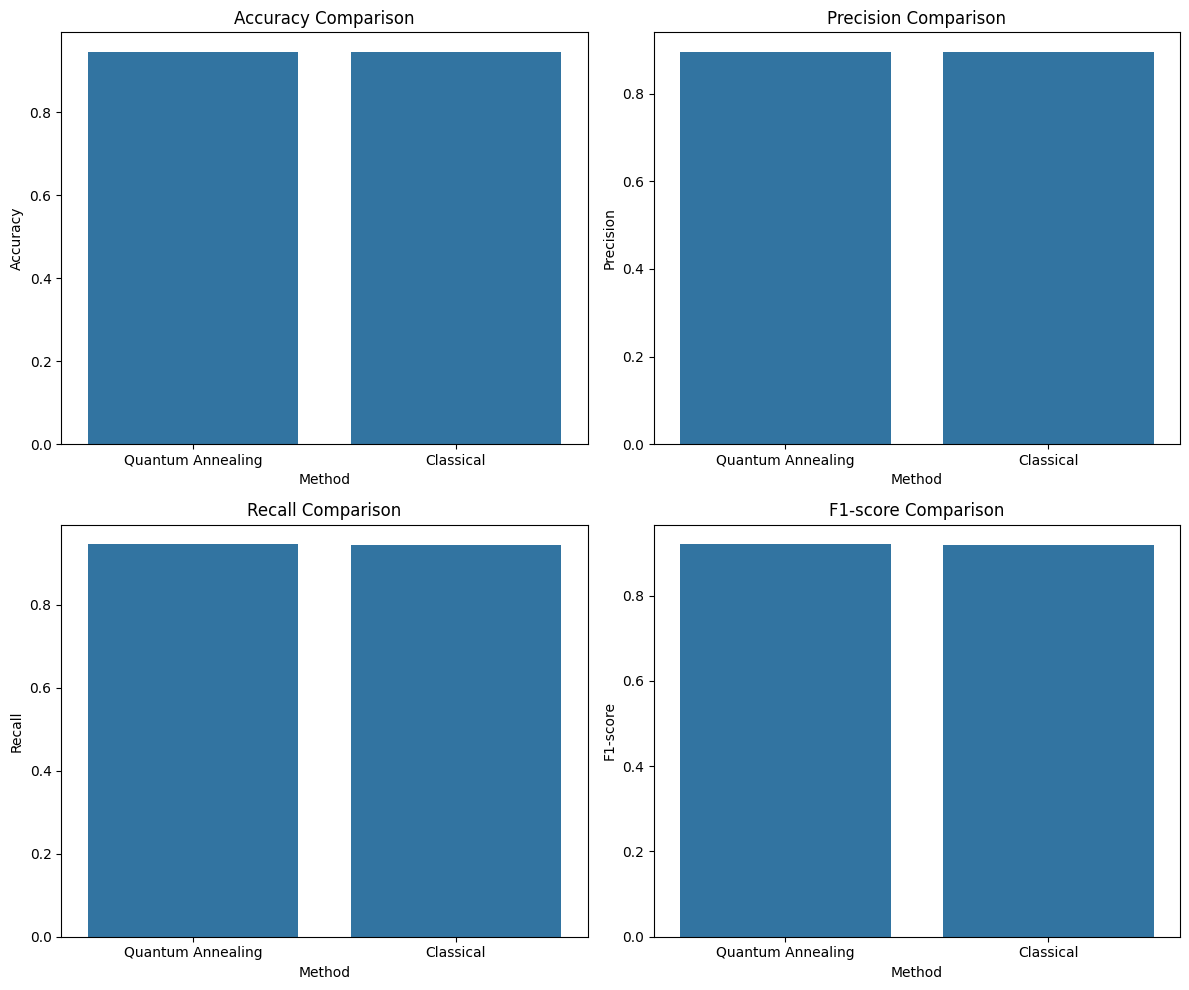

In [ ]:
run_evaluation(X, y, 'Stroke', num_features)